In [1]:
import os
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
plt.rcParams['figure.figsize']=(5, 5)
plt.rcParams['figure.dpi'] = 100
sc.settings.verbosity = 3
sc.settings.figdir = '../figures/'
sc.logging.print_versions()
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2 

scanpy==1.4.4.post1 anndata==0.7.4 umap==0.3.10 numpy==1.19.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 louvain==0.6.1


In [2]:
adata = sc.read('./../../data/processed/pvn_renamed_latest.h5ad')

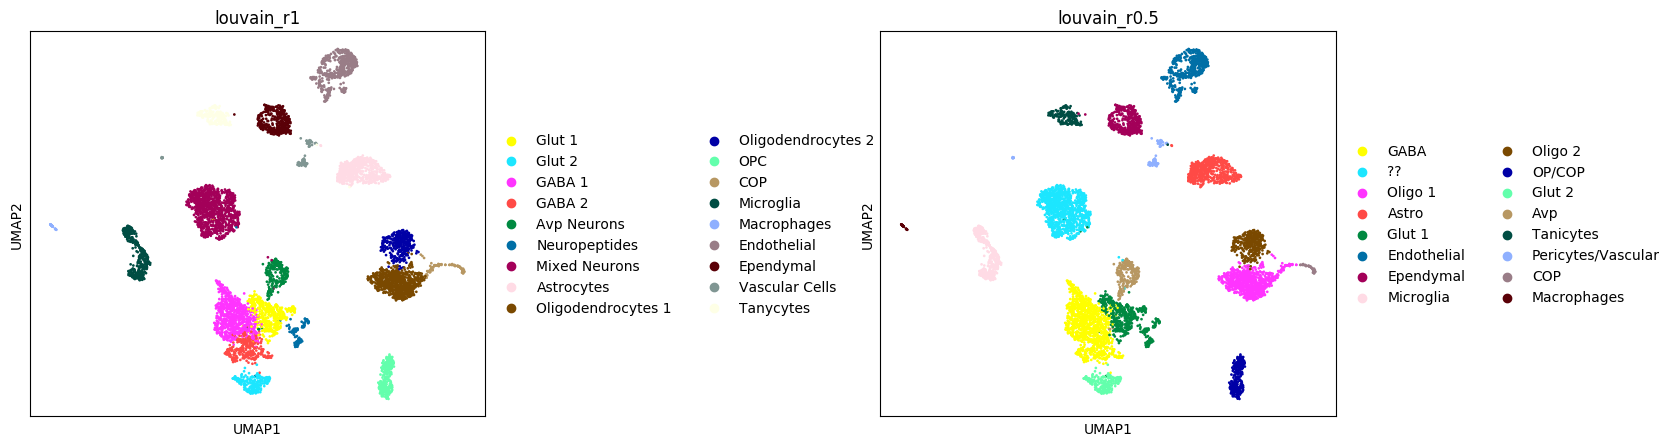

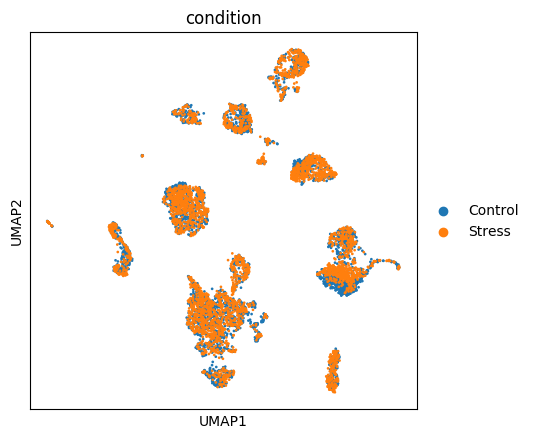

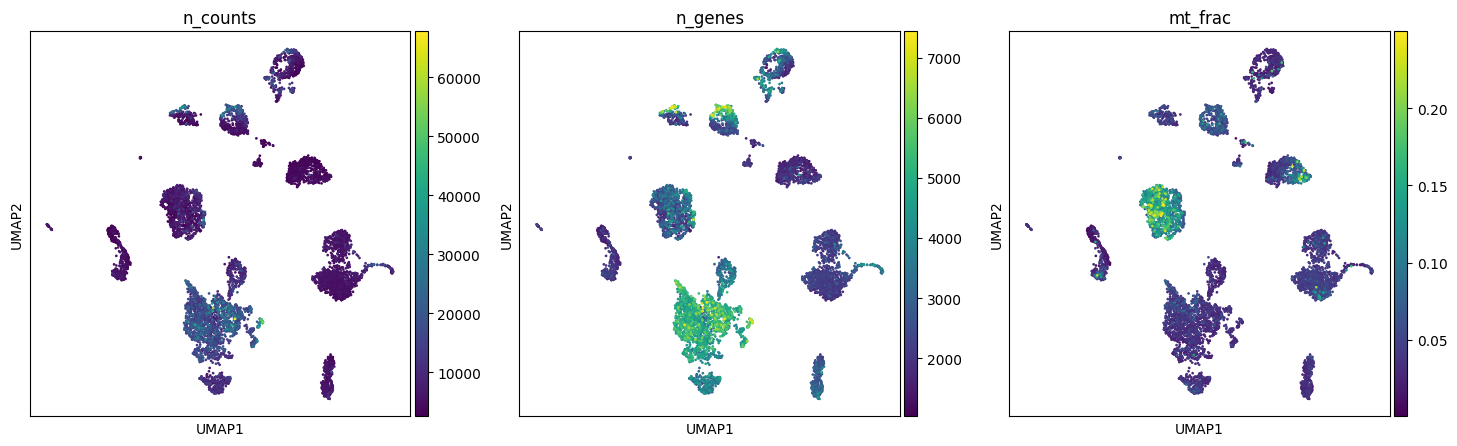

In [3]:
#Visualize the clustering and how this is reflected by different technical covariates
plt.rcParams['figure.figsize'] = (5, 5)
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], size=15, wspace=0.7)
sc.pl.umap(adata, color=['condition'], size=15)
sc.pl.umap(adata, color=['n_counts', 'n_genes', 'mt_frac'], size=15)

# Marker genes

In [4]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


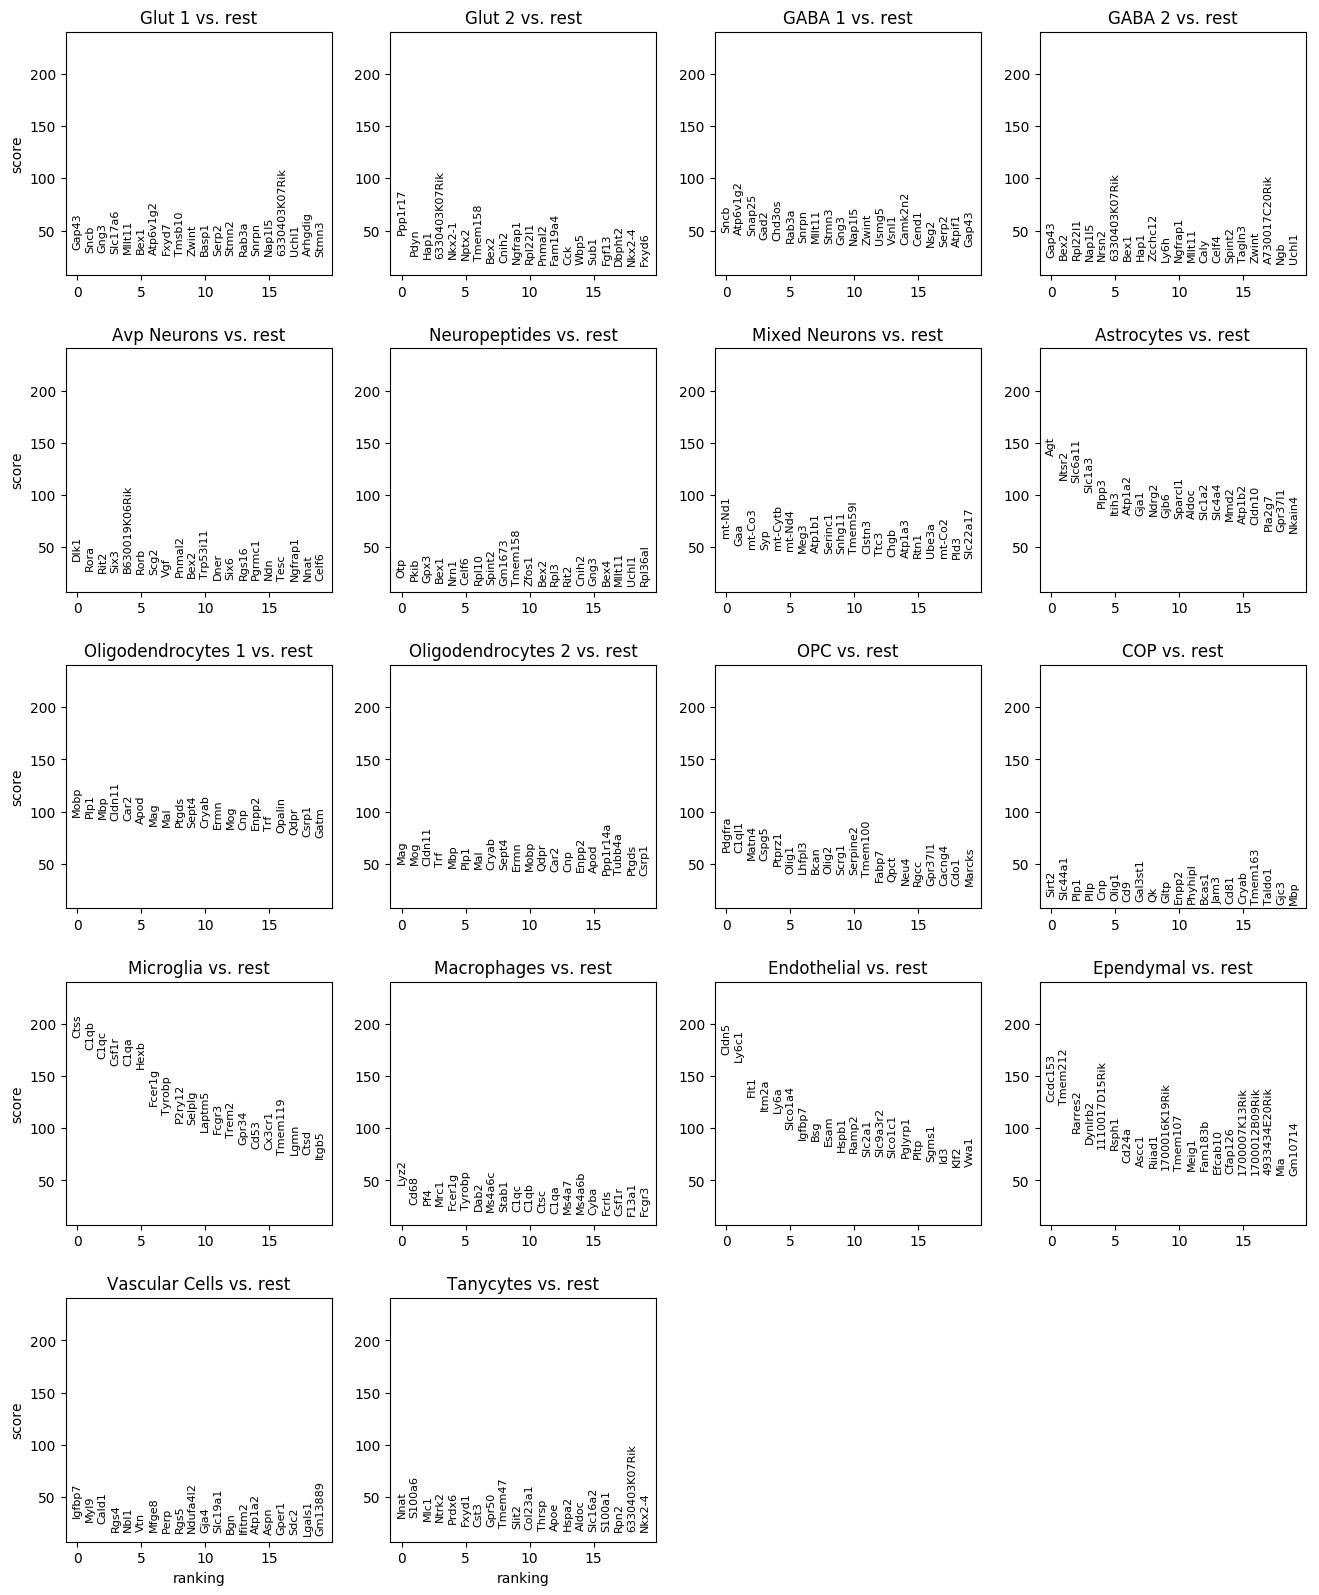

In [5]:
plt.rcParams['figure.figsize'] = (4,4)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1')

In [5]:
writer = pd.ExcelWriter('adrenal_r1_markers_pval.xlsx', engine='xlsxwriter')
names = adata.uns['rank_genes_r1']['names']
scores = adata.uns['rank_genes_r1']['scores']
pval = adata.uns['rank_genes_r1']['pvals']
adjp = adata.uns['rank_genes_r1']['pvals_adj']
foldchanges = adata.uns['rank_genes_r1']['logfoldchanges']
for clust in adata.obs['louvain_r1'].cat.categories:
        pd.DataFrame({'Names':names[clust],
                      'Scores':scores[clust],
                      'pval': pval[clust],
                      'adj_pval': adjp[clust],
                      'Log2foldchanges':foldchanges[clust]}).to_excel(writer,sheet_name=clust)
writer.save()

del scores, names, writer, foldchanges, clust

In [6]:
marker_genes = dict()
filepath = './../../data/pvn_markers.txt'
with open(filepath) as fp:
    for cnt, line in enumerate(fp):
        if cnt > 0:
            gene, cell= line.split('\t')
            cell = cell.rstrip('\n')
            if cell not in set(marker_genes.keys()):
                marker_genes[cell] = [gene]
            else:
                marker_genes[cell].append(gene)

In [7]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r1')

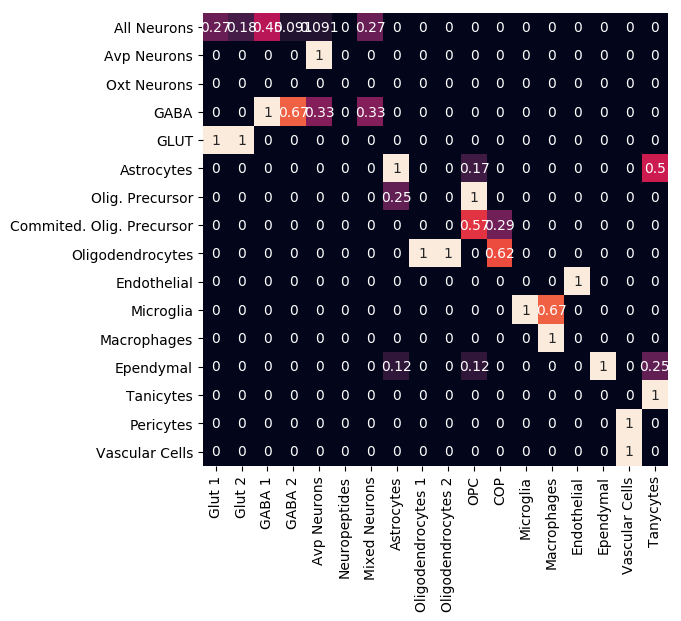

In [8]:
plt.rcParams['figure.figsize'] = (6, 6)
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r1', normalize='reference')
sns.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [ ]:
#Plot marker genes
n_groups=16
fig, ax = plt.subplots(5, 1)
j = 0
for i in np.arange(0, n_groups, 3):
    ax[0, j] = sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=[adata.obs['louvain_r1'].unique()[i],\
                                                            adata.obs['louvain_r1'].unique()[i+1],\
                                                            adata.obs['louvain_r1'].unique()[i+2]], fontsize=12, show=False)
    j += 1